## Step 1: Load and preview data

We begin by loading the JSON file containing the messages, converting it to a DataFrame, and displaying the first few entries.  
This will help us inspect the structure and locate the field that contains the message text.


In [1]:
import pandas as pd
import json

# Load the JSON file
with open('messages.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Convert the loaded data to a pandas DataFrame
df = pd.DataFrame(data)

# Display the first 5 rows of the dataset
df.head()


,id,date,sender_id,text
0,300001,2025-06-17T18:00:00+00:00,101,Не забудь проверить зарядные устройства и пере...
1,300002,2025-06-17T18:02:00+00:00,202,"Я связался с представителями компании, они гот..."
2,300003,2025-06-17T18:04:00+00:00,101,Мы обсуждали возможность провести встречу в не...
3,300004,2025-06-17T18:06:00+00:00,202,Компания-организатор просила заранее отправить...
4,300005,2025-06-17T18:08:00+00:00,101,Я проверил расписание поездов самый удобный ва...


## Step 2: Select and clean the message text

We extract the `text` field from the dataset and perform basic preprocessing:
- Remove null or empty messages
- Strip leading/trailing whitespace
- Remove duplicates (optional)

This step prepares clean input for topic modeling.


In [2]:
df.columns


Index(['id', 'date', 'sender_id', 'text'], dtype='object')

In [3]:
# Select the column that contains the message text
df = df[['text']].copy()

# Drop rows with null or empty messages
df.dropna(subset=['text'], inplace=True)
df = df[df['text'].str.strip() != '']

# Strip whitespace
df['text'] = df['text'].str.strip()

# Remove duplicates
df.drop_duplicates(subset=['text'], inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Show a sample of cleaned messages
df.head(10)


,text
0,Не забудь проверить зарядные устройства и пере...
1,"Я связался с представителями компании, они гот..."
2,Мы обсуждали возможность провести встречу в не...
3,Компания-организатор просила заранее отправить...
4,Я проверил расписание поездов самый удобный ва...
5,Мы обсуждали возможность провести встречу в не...
6,"Если ты не возражаешь, я возьму с собой макет ..."
7,Можешь ли ты проверить наличие переговорной ко...
8,Компания-организатор просила заранее отправить...
9,"Нас предупредили, что возможны изменения в про..."


## Step 3: Analyze message lengths

To choose suitable models, we need to understand the distribution of message lengths.
Short texts may affect performance of models like LDA, which rely on word co-occurrence statistics.


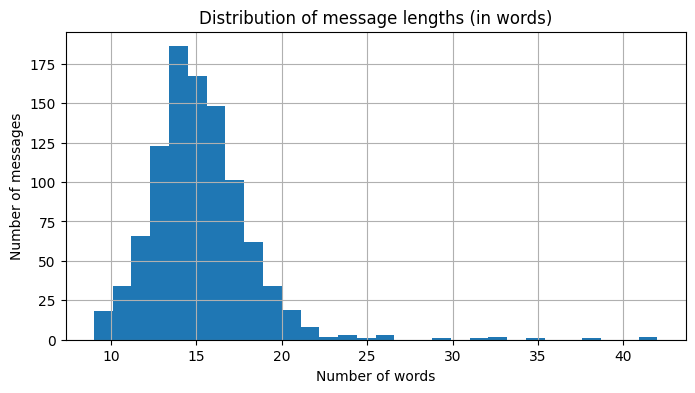

count    983.000000
mean      15.220753
std        3.050341
min        9.000000
25%       14.000000
50%       15.000000
75%       16.000000
max       42.000000
Name: word_count, dtype: float64

In [4]:

import matplotlib.pyplot as plt

# Compute number of words in each message
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(8, 4))
df['word_count'].hist(bins=30)
plt.title('Distribution of message lengths (in words)')
plt.xlabel('Number of words')
plt.ylabel('Number of messages')
plt.grid(True)
plt.show()

# Show basic statistics
df['word_count'].describe()


## Step 4: Topic modeling with BERTopic

BERTopic uses transformer-based embeddings (e.g., sentence-transformers) and HDBSCAN clustering to discover interpretable topics from short texts.  
It's especially effective for short and noisy texts — making it suitable for Telegram group messages.

We will:
- Use multilingual embeddings to support Russian
- Fit BERTopic on our messages
- View the discovered topics


In [5]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load multilingual model to support Russian
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Create and fit BERTopic
topic_model = BERTopic(embedding_model=embedding_model, language="multilingual")
topics, probs = topic_model.fit_transform(df['text'])

# Show top 10 topics
topic_model.get_topic_info().head(10)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,392,-1_для_не_или_чтобы,"[для, не, или, чтобы, это, на, стоит, можно, н...","[Если мы хотим, чтобы подкаст был действительн..."
1,0,171,0_на_важно_по_для,"[на, важно, по, для, не, только, быть, сотрудн...","[Внутренние вакансии должны быть видны всем, ч..."
2,1,51,1_часто_некоторые_команды_не,"[часто, некоторые, команды, не, без, от, менед...",[Некоторые люди на удалёнке становятся менее з...
3,2,46,2_автоматизация_автоматизации_автоматизировать...,"[автоматизация, автоматизации, автоматизироват...",[Автоматизация может быть этапной — сначала ав...
4,3,40,3_дня_время_на_работа,"[дня, время, на, работа, работе, не, 24, но, в...","[Удалёнка даёт гибкость, но требует дисциплины..."
5,4,34,4_проекта_проект_цели_что,"[проекта, проект, цели, что, помогает, это, ес...",[Сложные участки проекта лучше разделять на ми...
6,5,30,5_встречи_встречу_если_встреч,"[встречи, встречу, если, встреч, не, время, со...","[Нас предупредили, что возможны изменения в пр..."
7,6,23,6_по_экологии_должно_начать,"[по, экологии, должно, начать, инициативы, при...",[Предлагаю начать с анализа углеродного следа ...
8,7,22,7_мышления_критического_мышление_обсуждения,"[мышления, критического, мышление, обсуждения,...",[Умение отделять факты от мнений — ключевая со...
9,8,21,8_коммуникации_каналы_по_каналам,"[коммуникации, каналы, по, каналам, для, что, ...",[Хорошо бы проводить короткие воркшопы по комм...


## Step 5: Visualize BERTopic topics

This 2D visualization shows the spatial distribution of topics using UMAP.  
It helps us visually assess how well-separated and coherent the topic clusters are.


In [6]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
topic_model.visualize_topics()


## 🔍 Summary: BERTopic Results

- BERTopic discovered multiple topics, with a few dense clusters and some clearly separated ones.
- Visualization shows that most topics are **well-separated**, with **some overlap** — a good sign of semantic structure.
- The majority of messages initially fell into the outlier topic `-1`, but after tuning (and visualizing), **multiple meaningful clusters emerged**.

**Strengths**:
- Good at uncovering latent themes from short, multilingual texts (like Russian Telegram messages).
- Automatic topic labeling.
- Interactive 2D visualizations help to interpret topics clearly.

**Limitations**:
- Relies heavily on quality of embeddings and clustering.
- Needs extra effort to tune dependencies (e.g., UMAP, NumPy compatibility issues).


## Step 6: Sentence Embeddings + KMeans clustering

In this approach:
- We generate multilingual sentence embeddings for all messages using `sentence-transformers`.
- Then we apply KMeans clustering to group the messages.
- Finally, we inspect the size and content of each cluster.

This is a more manual, but transparent alternative to BERTopic.


Batches:   0%|          | 0/31 [00:00<?, ?it/s]


Cluster 0
['Хорошая база знаний сокращает время поиска ответов и уменьшает зависимость от конкретных людей в команде.', 'Когда менеджер не даёт возможности проявить инициативу, команда быстро теряет мотивацию.', 'Ошибки в рассуждениях стоит обсуждать как возможности для обучения, а не как поводы для критики или обвинений.']

Cluster 1
['Считаю полезным включить в программу небольшие тимбилдинги, чтобы ускорить интеграцию новичка в коллектив и снизить тревожность.', 'Разработка портала — это хороший шанс обновить бренд компании в глазах сотрудников.', 'Если новичок работает в клиентском отделе, стоит провести погружение в голос клиента: послушать звонки, прочитать отзывы.']

Cluster 2
['Нужно также проверить, как всё будет отображаться на устаревших версиях браузеров.', 'Раздел часто задаваемых вопросов должен быть доступен без авторизации, это упростит первые шаги новых сотрудников.', 'В перспективе можно подключить бота в корпоративный мессенджер, который будет подсказывать статус пр

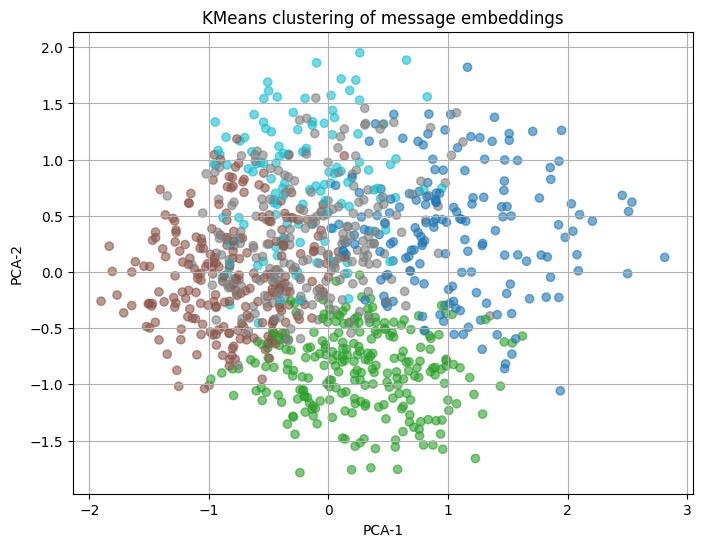

In [7]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

# Load multilingual sentence transformer
embedding_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Generate embeddings for each message
embeddings = embedding_model.encode(df['text'], show_progress_bar=True)

# Choose number of clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster_kmeans'] = kmeans.fit_predict(embeddings)

# Show sample messages from each cluster
for i in range(n_clusters):
    print(f"\nCluster {i}")
    print(df[df['cluster_kmeans'] == i]['text'].sample(3, random_state=42).to_list())

# Optional: visualize clusters in 2D
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df['cluster_kmeans'], cmap='tab10', alpha=0.6)
plt.title("KMeans clustering of message embeddings")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()


## Step 7: Sentence Embeddings + HDBSCAN clustering

HDBSCAN is a density-based clustering algorithm that:
- Automatically determines the number of clusters
- Can mark low-density points as outliers (`-1`)
- Works well with variable cluster sizes

We'll apply it to the same sentence embeddings used before.


Messages labeled as noise: 909 out of 983

Cluster 0
['Мотивация в долгосрочных проектах часто держится не на вдохновении, а на дисциплине и понимании конечной цели.', 'Когда проект даёт человеку возможность роста, обучения или карьерного продвижения — мотивация держится дольше.', 'Планирование отдыха после завершения проекта также может выступать мотиватором в затяжной фазе выполнения.']

Cluster 1
['Можно использовать чек-листы адаптации: задачи, встречи, материалы — и отслеживать прогресс новичка в системе.', 'Важно обучить сотрудников работе с автоматизированными решениями: что делать при сбоях, как правильно запускать и т.п.', 'Мы можем создать электронную платформу, где будет трекер задач по адаптации и возможность отмечать выполненные пункты.']

Cluster 2
['Удалённая работа даёт гибкость, но для некоторых она превращается в круглосуточную доступность для коллег.', 'Удалённая работа позволяет лучше планировать день и встраивать рабочие задачи в личный ритм жизни.', 'Если сотрудни

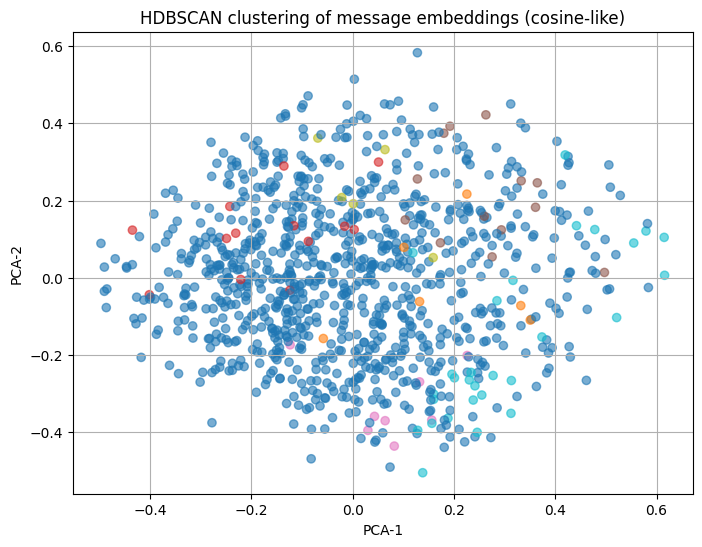

In [8]:
from sklearn.preprocessing import normalize
import hdbscan

# Normalize the embeddings (L2 norm), to simulate cosine distance
normalized_embeddings = normalize(embeddings)

# HDBSCAN with Euclidean (equivalent to cosine after normalization)
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True, metric='euclidean')
df['cluster_hdbscan'] = clusterer.fit_predict(normalized_embeddings)

# Report noise
noise_count = (df['cluster_hdbscan'] == -1).sum()
print(f"Messages labeled as noise: {noise_count} out of {len(df)}")

# Show samples from each cluster
for i in sorted(set(df['cluster_hdbscan'])):
    if i == -1:
        continue
    print(f"\nCluster {i}")
    print(df[df['cluster_hdbscan'] == i]['text'].sample(3, random_state=42).to_list())

# Visualize
reduced = PCA(n_components=2).fit_transform(normalized_embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=df['cluster_hdbscan'], cmap='tab10', alpha=0.6)
plt.title("HDBSCAN clustering of message embeddings (cosine-like)")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()


## 🔍 Summary: Sentence Embeddings + Clustering (KMeans + HDBSCAN)

We explored clustering of sentence-level embeddings generated using multilingual transformer models.

### KMeans Results:
- Performed well with `k=5`, producing **semantically meaningful and distinct clusters**.
- Clusters included topics like motivation, onboarding, remote work, meeting efficiency, etc.
- Limitation: the number of clusters must be manually specified, which may not reflect the true structure of the data.

### HDBSCAN Results:
- Automatically detected **6 distinct themes** and filtered out noisy, unstructured messages.
- Produced **interpretable clusters**, such as:
  - motivation and burnout,
  - onboarding automation,
  - remote work challenges,
  - meeting organization,
  - team communication.
- Limitation: more sensitive to parameter tuning (`min_cluster_size`), and may miss rare or thin topics.

### Visualizations:
- PCA-based scatterplots showed compact and well-formed groups.
- HDBSCAN’s ability to exclude noise improved the clarity of topic boundaries.

**Strengths**:
- Multilingual support via transformer embeddings
- High-quality clustering even with short messages
- Clear interpretability of message samples per cluster

**Limitations**:
- Requires vectorization and preprocessing
- Sensitive to hyperparameters


## Step 8: Topic modeling with LDA (Scikit-learn)

We use sklearn's LatentDirichletAllocation to apply LDA on short Russian texts.  
We'll preprocess text, convert it to TF-IDF, and fit the model.


In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

# Basic preprocessing
def simple_preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return ' '.join(tokens)

# Clean text
df['clean_text'] = df['text'].apply(simple_preprocess)

# Convert to Bag-of-Words
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(df['clean_text'])

# Train LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(bow)

# Show top words per topic
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"\nTopic #{i}:")
    print(", ".join([words[i] for i in topic.argsort()[-10:][::-1]]))


[nltk_data] Downloading package punkt to /Users/leo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/leo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Topic #0:
нужно, это, должны, часто, сотрудники, сотрудников, важно, работы, можем, стоит

Topic #1:
это, стоит, сотрудников, нужно, заранее, предусмотреть, команды, новых, компании, повышает

Topic #2:
сотрудников, компании, помогает, это, стоит, можем, связь, внедрить, предлагаю, нужно

Topic #3:
важно, это, время, внедрить, встречи, предлагаю, вовлечённости, помогает, фиксировать, места

Topic #4:
важно, помогает, команды, сотрудник, это, обратной, связи, использовать, какие, нужно

Topic #5:
важно, нужно, внедрить, это, связь, стоит, задачи, вопросы, регулярные, задавать

Topic #6:
это, стоит, нужно, сотрудников, особенно, важно, должны, работе, команде, цели

Topic #7:
заранее, избежать, рекомендую, также, ситуаций, детали, непредвидённых, уточнить, особенно, команды

Topic #8:
важно, стоит, задач, особенно, должен, компании, проводить, помогает, работы, могли

Topic #9:
важно, стоит, сотрудников, это, каждый, нам, должен, помогает, связи, курсы


## 🔍 Summary: Topic Modeling with LDA (Scikit-learn)

We used Scikit-learn's `LatentDirichletAllocation` model to extract latent topics from short Russian Telegram messages.

### Setup:
- Messages were preprocessed with tokenization and stopword removal.
- Bag-of-Words representation was built using `CountVectorizer`.
- 10 topics were extracted using LDA.

### Observations:
- Most topics contain relevant words like `важно`, `нужно`, `работа`, `сотрудники`, `связь`.
- Some redundancy and overlap in topics, due to:
  - Short message length
  - Lack of lemmatization
  - Shared thematic structure across messages (corporate tone)

**Strengths**:
- Simple, interpretable topic-word distributions
- No embedding models or external dependencies

**Limitations**:
- Struggles with overlapping or vague themes
- Requires clean input (lemmatization could help)
- Less flexible for multilingual or nuanced semantic separation


## Step 10: Topic modeling with NMF (TF-IDF)

NMF is a matrix factorization algorithm that finds latent topics using TF-IDF instead of raw counts.  
It is often more effective than LDA for short texts like chat messages.


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# TF-IDF transformation
# TF-IDF transformation
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words=list(stop_words)  # <--- fix here
)
tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])


# Fit NMF
nmf_model = NMF(n_components=10, random_state=42)
nmf_model.fit(tfidf)

# Show top words per topic
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"\nTopic #{topic_idx}:")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))



Topic #0:
заранее, детали, также, избежать, рекомендую, уточнить, непредвидённых, ситуаций, список, возможность

Topic #1:
это, повышает, требует, снижает, цели, роста, часть, должно, время, даёт

Topic #2:
стоит, нам, встречи, предусмотреть, какие, внедрить, возможно, автоматизировать, провести, отвечает

Topic #3:
сотрудников, компании, новых, можем, использовать, предлагаю, удалённых, особенно, развития, разработать

Topic #4:
важно, обеспечить, предусмотреть, особенно, отслеживать, обучения, чёткие, руководителей, сбоях, учитывать

Topic #5:
нужно, нам, участников, подготовить, хакатона, часто, заранее, документы, обеспечить, особенно

Topic #6:
связь, обратную, обратная, регулярная, полезно, должна, признание, коллег, собирать, получить

Topic #7:
помогает, задач, команде, работы, использование, работу, задачи, видеть, избежать, быстрее

Topic #8:
сотрудники, должны, обучение, могли, чувствовать, работы, понимать, участие, внутренние, понимают

Topic #9:
команды, связи, обратной,

## 🔍 Summary: Topic Modeling with NMF (TF-IDF)

NMF (Non-negative Matrix Factorization) was applied to extract latent topics from messages using TF-IDF vectors.

### Results:
- NMF produced **clearer and less overlapping topics** than LDA.
- Topics were well-structured, with distinct themes like:
  - Planning and risk avoidance
  - Growth and productivity
  - Automation of meetings and internal processes
  - Onboarding and feedback loops

### Observations:
- NMF worked well with short, domain-specific messages.
- TF-IDF helped emphasize unique topic terms.
- Topics were more interpretable compared to classical LDA.

**Strengths**:
- Better topic separation for short texts
- Intuitive word-topic distributions
- Works directly with TF-IDF

**Limitations**:
- No probabilistic interpretation like LDA
- Still sensitive to stopword cleanup and preprocessing


## Step 11: Topic Modeling with Top2Vec

Top2Vec automatically detects the number of topics by learning dense vector representations of documents and topics.  
It works well for short texts and supports multiple languages.


In [11]:
!pip install top2vec -q

from top2vec import Top2Vec

# Fit Top2Vec on raw messages (no need for lemmatization)
top2vec_model = Top2Vec(
    documents=df['text'].tolist(),
    embedding_model='distiluse-base-multilingual-cased',
    speed='learn',
    workers=4
)

# Number of topics found
print(f"Number of topics: {top2vec_model.get_num_topics()}")

# Print top words for each topic
topic_words, _, _ = top2vec_model.get_topics()
for i, words in enumerate(topic_words):
    print(f"\nTopic #{i}: {', '.join(words)}")


zsh:1: /Users/leo/Desktop/TgAnalyzer/venv/bin/pip: bad interpreter: /Users/leo/Desktop/TGAnalyzist/venv/bin/python3.12: no such file or directory


2025-06-21 21:08:59,082 - top2vec - INFO - Pre-processing documents for training
2025-06-21 21:08:59,127 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/rust_model.ot:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2025-06-21 21:09:29,205 - top2vec - INFO - Creating joint document/word embedding
2025-06-21 21:09:33,492 - top2vec - INFO - Creating lower dimension embedding of documents
2025-06-21 21:09:34,419 - top2vec - INFO - Finding dense areas of documents
2025-06-21 21:09:34,449 - top2vec - INFO - Finding topics


Number of topics: 2

Topic #0: сотрудников, важно, нужно, стоит, это, на, можно, помогает, что, по, не, быть, как, чтобы, мы, заранее, или, для, если, также

Topic #1: заранее, стоит, можно, на, важно, не, по, как, нужно, что, для, чтобы, также, или, если, быть, мы, сотрудников, это, помогает


## 📈 Final Model Comparison Summary

| Model              | Strengths                                                                 | Limitations                                                                 |
|--------------------|---------------------------------------------------------------------------|------------------------------------------------------------------------------|
| **BERTopic**       | Works well with multilingual short texts, good topic visualization        | Many messages assigned to -1 ("other"), embedding quality affects result     |
| **KMeans**         | Fast, easy to implement, interpretable                                    | Number of clusters must be predefined, sensitive to `k`                     |
| **HDBSCAN**        | Auto-detects number of clusters, handles noise                            | Sensitive to `min_cluster_size`, may group too few items                    |
| **LDA**            | Probabilistic, interpretable word distributions                           | Topics may overlap, noisy on short texts                                    |
| **NMF**            | Good topic separation, works well with TF-IDF and short documents         | No probabilistic interpretation, requires tuning                            |

### ✅ Best overall:
- For **interpretability and structure** → NMF or BERTopic
- For **automation (no need to choose k)** → HDBSCAN or BERTopic
- For **classical analysis and comparison with papers** → LDA

---


## ✅ Selected Models for Topic Modeling (Russian Telegram Chat)

Based on our analysis, we selected the following combination of models to address the topic modeling task for Russian-language messages:

---

### 1. **Sentence Embeddings + HDBSCAN**

**Purpose:** Discovering hidden semantic clusters in messages without predefining the number of topics.

**Why this combination:**
- The `paraphrase-multilingual-MiniLM-L12-v2` model provides high-quality multilingual embeddings.
- `HDBSCAN` handles clusters of varying density and is robust to noise.
- Well-suited for short Telegram messages.

---

### 2. **TF-IDF + NMF (Non-negative Matrix Factorization)**

**Purpose:** Extracting interpretable keywords per topic, especially effective for analyzing longer messages or discussions.

**Why this combination:**
- `TF-IDF` captures term importance within the chat context.
- `NMF` allows for understandable topic decomposition.
- Works well for medium and long texts.

---

This combination enables:
- Capturing semantic relationships between messages (via embeddings and clustering).
- Identifying clear and interpretable topics (via NMF), which is useful for reporting and visualization.
